In [1]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

finwiz_url = 'https://finviz.com/quote.ashx?t='

In [12]:
news_tables = {}
tickers = ['XOM', 'JNJ', 'DD']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [14]:
# Read one single day of headlines for 'AMZN' 
amzn = news_tables['DD']
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 7:
        break

Play DuPont Technique to Bet on 5 Top-Ranked Stocks
Aug-26-20 04:53PM  
DuPont Names Lavoisier and Pedersen Award Medalists
Aug-25-20 10:30AM  
Why DuPont de Nemours (DD) Stock is a Compelling Investment Case
Aug-24-20 12:57PM  
First Eagle Investment Exits JD,com, Cuts Broadcom
Aug-13-20 01:15PM  
Top 2nd-Quarter Trades of First Pacific Advisors
Aug-12-20 06:30PM  
Go With the Upside Breakout on DuPont
01:10PM  
Zacks.com featured highlights include: Medifast, USANA Health, UFP Industries, AllianceBernstein and Landstar System
Aug-05-20 09:48AM  
6 Must-Buy Quality Stocks Screened on DuPont Analysis
Aug-04-20 09:23AM  


In [15]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
parsed_news

[['XOM',
  'Aug-28-20',
  '08:01PM',
  'Salesforce Rises After Its Included in the Dow. But Earnings Drive the Stock Even More.'],
 ['XOM',
  'Aug-28-20',
  '02:49PM',
  "Dow's 150-point jump highlighted by gains for Walmart, Coca-Cola stocks"],
 ['XOM', 'Aug-28-20', '02:00PM', 'Oil Prices Fall As Hurricane Fears Subside'],
 ['XOM',
  'Aug-28-20',
  '12:27PM',
  'Exxon Removed From the Dow After Nearly 100 Years: What It Means for Investors'],
 ['XOM',
  'Aug-28-20',
  '10:01AM',
  'Hurricane Laura causes billions in damage on Gulf Coast'],
 ['XOM',
  'Aug-28-20',
  '09:49AM',
  "Here's Why Chevron Is the Last Oil Stock in the Dow and Not ExxonMobil"],
 ['XOM',
  'Aug-28-20',
  '09:47AM',
  "Dow's nearly 75-point climb led by gains in shares of Walmart, Coca-Cola"],
 ['XOM',
  'Aug-27-20',
  '03:39PM',
  'Oil outlook as Hurricane Laura pounds Gulf Coast'],
 ['XOM',
  'Aug-27-20',
  '11:23AM',
  'U.S. energy firms tally hurricane damage, plot restarts as Laura races north'],
 ['XOM', 'A

In [16]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,XOM,2020-08-28,08:01PM,Salesforce Rises After Its Included in the Dow...,0.000,1.000,0.000,0.0000
1,XOM,2020-08-28,02:49PM,Dow's 150-point jump highlighted by gains for ...,0.000,0.789,0.211,0.3400
2,XOM,2020-08-28,02:00PM,Oil Prices Fall As Hurricane Fears Subside,0.318,0.682,0.000,-0.4215
3,XOM,2020-08-28,12:27PM,Exxon Removed From the Dow After Nearly 100 Ye...,0.000,1.000,0.000,0.0000
4,XOM,2020-08-28,10:01AM,Hurricane Laura causes billions in damage on G...,0.286,0.714,0.000,-0.4939


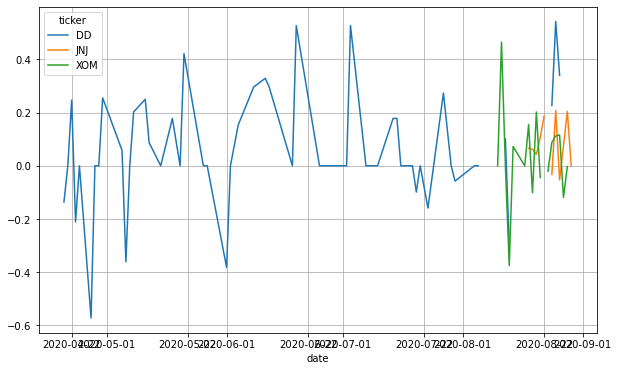

In [18]:
plt.rcParams['figure.figsize'] = [10, 6]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'line')
plt.grid()